# <font color='red'> Cycle 01 - Clusters validation metrics </font>

1. Feature Engineering (FRM)
- Recency
- Frequency
 - Monetary
2. Cluster validation metrics
- WSS (Within-Cluster Sum of Square)
- SS (Silhouette Score)
3. Cluster Analysis
- Plot 3D
- Cluster Profile

# <font color='red'> Cycle 02 - Silhouette Analysis </font>

1. Feature Engineering (FRM)
- Avg ticket
2. Silhouette Analysis
3. Cluster Visualization
- UMAP
4. Cluster profile analysis
- Description of cluster centroids

# <font color='red'> Cycle 03 - Descriptive Statistical </font>

1. Descriptive Analysis
- Numerical attributes
- Categorical attributes
2. Feature Engineering
- Average recency
- Number of returns
3. Data Preparation
- Standard Scaler

# 0.0 SOLUTION PLANNING (IOT)

**Input**
1. Business Problem
    - Select the most valuable customers to join a loyalty program (Insiders program).
#
2. Data
    - E-commerce sales over 1 year period.

**Output**

1. The indication of people who will be part of the Insiders program
    - List:          client_id | is_insider |
#
2. Report containing the solutions for the business questions

- Who are eligible to participate the Insiders program?

- How many customers will be part of the group?

- What are the mainly characteristics of there customers?

- What is the % of revenue coming of these customers?

- What's the revenue expectation for this group next month?

- What are the conditions for someone to be eligible for insiders?

- What are the conditions for someone to be removed from insiders?

- What is the guarantee that the Insiders program is best than the remaining base?

- What actions the marketing team can do for increasing the revenue?


#### Tasks

1. **Report with answers**:

- 1. Who are eligible to participate the Insiders program?
    - What is being eligible? What are the most valuable customers?
        - Shopping experience
        - Basket size
        - Higher LTV
        - Higher average ticket
        - Low probability of Churn 
        - Higher shopping probability
        - Low devolution rate
        - Positive reviews        
#
- 2. How many customers will be part of the group?
    - Quantity of customers
    - % of Insiders group

#
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    #
    - Write shopping characteristics:
        - Clustering features
#
- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
#
- 5. What's the revenue expectation for this group next month?
    - Insiders group LTV
    - Cohort analysis
#
- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity
    - The customer needs to be similar to someone that is present in the group
#
- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity
    - The customer needs to be non imilar to someone that is present in the group
#
- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B Test
    - Baysean A/B Test
    - Hypothesis test
#
- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New employees
    - New products


## 0.1 Imports

In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import re

from matplotlib import pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import preprocessing as pp

from plotly import express as px

## 0.2 Helper functions

## 0.3 Load dataset

In [509]:
# load data
df_raw = pd.read_csv(r'C:\Users\diego\OneDrive\Área de Trabalho\Portfolio Projects\insiders-clustering\data\Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)



In [510]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [511]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [512]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [513]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [514]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [515]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [516]:
# spliting NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [517]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [518]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [519]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive statistics

In [520]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [521]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
quantity,9.552250,3.00,218.081158,-80995.00,80995.0,-0.264076,119769.160031
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,186.506972,59005.719097
customer_id,16688.840453,16249.00,2911.411352,12346.00,22709.0,0.487449,-0.804287


<font color='red'>**Some points:**</font>
- The minimum of 'quantity' is a negative value
- The minimum 'unit_price' is a negative value


### 1.7.2 Categorical attributes

### Invoice No

In [522]:
# df1['invoice_no'].astype(np.int64) - problem: invoice contains numbers and words

# identification
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]
df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))
print('Total number of negatives quantities: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices with letters: 9291
Total number of negatives quantities: 9288


### Stock Code

In [523]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Since this stock codes does not present a regular purchase operation, they will be removed from data

### Description

In [524]:
df1['description'].head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

Description will be deleted from data since it does not give any perceptive feature to the problem

### Country

In [525]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [526]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 VARIABLES FILTERING

In [527]:
df2 = df1.copy()

In [528]:
# ==== Numerical Attributes ====
# unit price > 0
df2= df2.loc[df2['unit_price'] >= 0.04, :]

# ==== Categorical Attributes ====
# stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity - Negative numbers will be assumed as product returns
df2_returns = df2.loc[df2['quantity'] <= 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]


# 3.0 FEATURE ENGINEERING

In [529]:
df3 = df2.copy()

## 3.1 Feature creation

In [530]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                  'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [531]:
# Gross Revenue: quantity * price
df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)

# Monetary
df_monetary = df2_purchase[[ 'customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()


C:\Users\diego\AppData\Local\Temp\ipykernel_3364\59910178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency

Day from last purchase

In [532]:
# Recency - Last day purchase

max_invoice_date = df2_purchase['invoice_date'].max()

df_recency = df2_purchase.loc[:, ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = df_recency['invoice_date'].apply(lambda x:  max_invoice_date - x).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of Purchases

In [533]:
# Quantity of purchases
df_prod = df2_purchase.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')
df_ref.head()


,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


In [534]:
df_prod.sort_values('customer_id')

,customer_id,invoice_no
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
5691,22705,1
5692,22706,1
5693,22707,1
5694,22708,1


### 3.1.4 Quantity of Products Purchased

In [535]:
# average quantity of products purchased by customer
df_prod = df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')


# total quantity of procucts purchased by customer
df_prod = df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')
df_ref = df_ref.rename(columns={'quantity_x': 'avg_quantity', 'quantity_y': 'total_quantity'})

df_ref.isna().sum()


customer_id        0
gross_revenue     91
recency_days      91
invoice_no        91
avg_quantity      91
total_quantity    91
dtype: int64

### 3.1.5 Average Ticket Value

In [536]:
# Avg ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
invoice_no        91
avg_quantity      91
total_quantity    91
avg_ticket        91
dtype: int64

### 3.1.6 Average Recency Days

In [537]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux ['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: x['invoice_date']-x['previous_date'] if x['customer_id'] == x['next_customer_id'] else
                                                    np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# avg recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency

In [538]:
df_ref1 = df_ref.copy()

In [539]:
df_aux = ( df3[['customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_=('invoice_date', 'max'), 
                                                                  min_=('invoice_date', 'min'),
                                                                  days_=('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                  buy_=('invoice_no', 'count')).reset_index())

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_aux.head()

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [540]:
df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

### 3.1.8 Returns

In [541]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns']*(-1)

df_ref1 = pd.merge(df_ref1, df_returns, on='customer_id', how='left')
df_ref1.loc[df_ref1['qty_returns'].isna(), 'qty_returns'] = 0
df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    2816
frequency              0
qty_returns            0
dtype: int64

### 3.1.9 Basket Size

In [542]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                             n_products=('quantity', 'sum'))
                                                        .reset_index()  )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    2816
frequency              0
qty_returns            0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size

In [543]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                             n_products=('stock_code', 'count'))
                                                        .reset_index()  )

# calculation
df_aux['avg_un_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'avg_un_basket_size']], how='left', on='customer_id')

df_ref1.isna().sum()

customer_id              0
gross_revenue           91
recency_days            91
invoice_no              91
avg_quantity            91
total_quantity          91
avg_ticket              91
avg_recency_days      2816
frequency                0
qty_returns              0
avg_basket_size         91
avg_un_basket_size      91
dtype: int64

# 4.0 EXPLORATORY DATA ANALYSIS

In [545]:
df4 = df_ref1.dropna()
df4.isna().sum()

customer_id           0
gross_revenue         0
recency_days          0
invoice_no            0
avg_quantity          0
total_quantity        0
avg_ticket            0
avg_recency_days      0
frequency             0
qty_returns           0
avg_basket_size       0
avg_un_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [552]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [554]:
df4.sort_values('gross_revenue', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,invoice_no,avg_quantity,total_quantity,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_un_basket_size
1017,14646,279138.02,1.0,72.0,95.555340,196844.0,135.503893,7 days 20:16:00,0.206215,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,148.779582,64124.0,602.453132,14 days 16:19:12,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,207.694362,69993.0,577.302047,12 days 19:42:51.428571428,0.136111,952.0,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,26999.000000,80997.0,56157.500000,205 days 00:00:00,0.014563,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,14.148246,80263.0,24.757751,2 days 14:26:00.839160839,0.651475,3332.0,403.331658,28.507538
1150,12415,124564.53,24.0,20.0,108.517532,77373.0,174.704811,20 days 20:48:00,0.076433,427.0,3868.650000,35.650000
190,14156,117379.63,9.0,55.0,41.346429,57885.0,83.842593,7 days 06:14:24,0.178571,859.0,1052.454545,25.454545
15,17511,91062.38,2.0,31.0,67.029076,64549.0,94.561142,11 days 14:15:00,0.120968,1535.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,166.834025,40207.0,302.415311,9 days 01:17:50.270270270,0.196429,8004.0,648.500000,3.887097
955,16684,66653.56,4.0,28.0,181.425993,50255.0,240.626570,22 days 03:00:00,0.084507,864.0,1794.821429,9.892857


In [556]:
df3[df3['customer_id'] == 14646].head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646
37957,539491,20751,1,2016-12-18,2.10,Netherlands,14646
37958,539491,21246,2,2016-12-18,4.95,Netherlands,14646
37959,539491,22960,1,2016-12-18,4.25,Netherlands,14646
37960,539491,22355,2,2016-12-18,0.85,Netherlands,14646
37961,539491,21123,2,2016-12-18,1.25,Netherlands,14646


In [557]:
np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])

278778.02

In [559]:
len(df3.loc[df3['customer_id'] == 14646, 'invoice_no'].unique())

73

In [561]:
df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()

196556

## 4.2 Bivariate Analysis

# 5.0 DATA PREPARATION

In [351]:
df5 = df4.copy()

In [352]:
ss= pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

<AxesSubplot:xlabel='gross_revenue', ylabel='Count'>

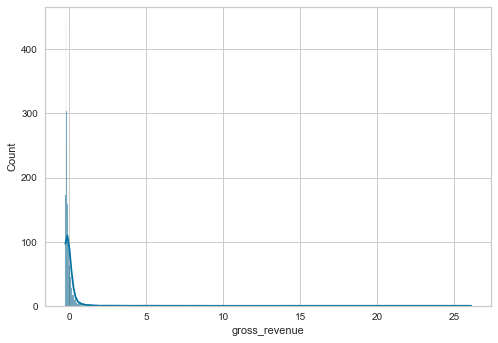

In [353]:
sns.histplot(df5['gross_revenue'], kde=True)

Gross revenue does not present a normal distribution (it will be treated in the next cycles)

# 6.0 FEATURE SELECTION

In [354]:
df6 = df5.copy()

#  7.0 HYPERPARAMETER FINE-TUNING

In [355]:
X = df6.drop(columns=['customer_id'])

In [356]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

In [357]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

TypeError: The DType <class 'numpy.dtype[timedelta64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

## 7.2 Silhouette score

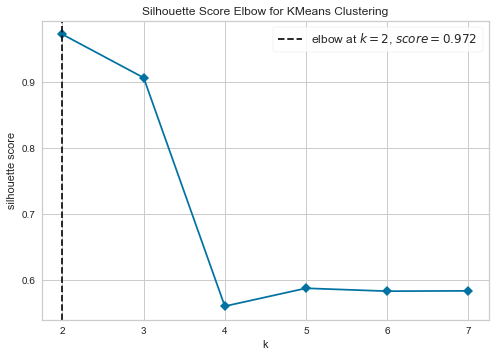

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Silhouette analysis

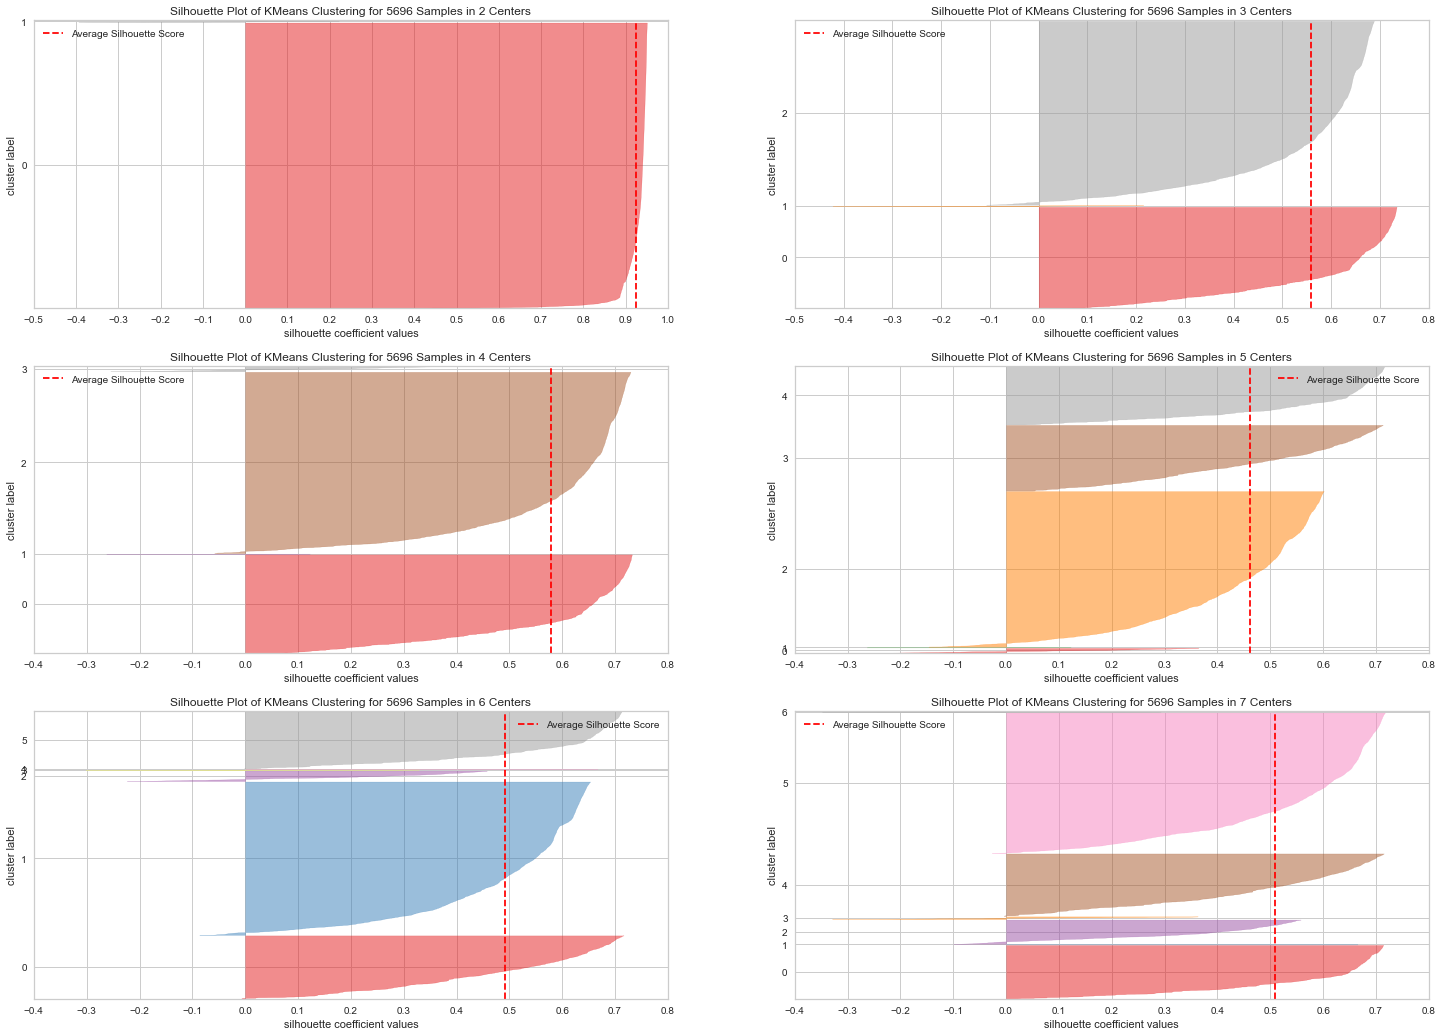

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 MODEL TRAINING

## 8.1 K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [ ]:
## WSS (Within-cluster Sum of Square)
print('wss value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'. format(m.silhouette_score(X, labels, metric='euclidean')))


wss value: 12410.173453176332
SS value: 0.5576394877714113


# 9.0 CLUSTER ANALYSIS

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization inspection

c:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


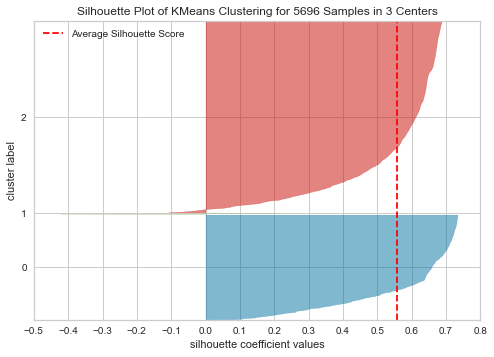

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

In [ ]:
df9.head()

,customer_id,gross_revenue,recency_days,avg_ticket,invoice_no,cluster
0,17850,0.454360,2.285010,-0.028444,4.481562,0
1,13047,0.180979,-0.545579,-0.027857,0.811636,2
2,12583,0.620794,-1.029288,-0.020054,1.692418,2
3,13748,-0.108323,-0.196234,-0.016180,0.224448,2
4,15100,-0.117473,1.935665,0.185277,-0.069146,0


In [ ]:
df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [ ]:
X.head()

,gross_revenue,recency_days,avg_ticket,invoice_no
0,0.454360,2.285010,-0.028444,4.481562
1,0.180979,-0.545579,-0.027857,0.811636
2,0.620794,-1.029288,-0.020054,1.692418
3,-0.108323,-0.196234,-0.016180,0.224448
4,-0.117473,1.935665,0.185277,-0.069146


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

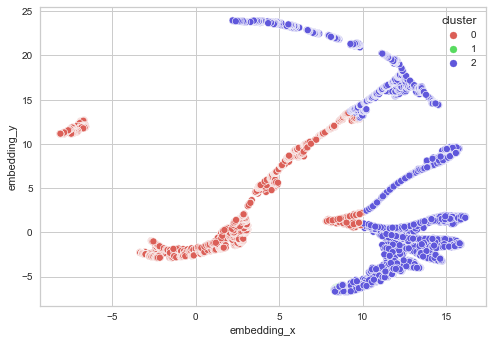

In [ ]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
                data= df_viz)

The clusterization showed worse in its metrics

## 9.2 Cluster profile

In [ ]:
# number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg invoice no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,2009,35.270365,-0.144219,1.206826,-0.319556,-0.020764
1,1,22,0.386236,11.712964,-0.870087,9.592769,4.814451
2,2,3665,64.343399,0.008745,-0.656309,0.117585,-0.017518


# 10.0 DEPLOY TO PRODUCTION